In [1]:
import pandas as pd
from sqlalchemy import create_engine
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from phik import phik_matrix
from dotenv import load_dotenv
import os

# Шаг 1. Загрузка данных и их предобработка
## Задача 1.1: Напишите SQL-запрос, выгружающий в датафрейм pandas

In [2]:
load_dotenv()

db_config = {
    'user': os.getenv('DB_USER'),
    'pwd': os.getenv('DB_PWD'),
    'host': os.getenv('DB_HOST'),
    'port': os.getenv('DB_PORT'),
    'db': os.getenv('DB_NAME')
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

engine = create_engine(connection_string) 

query = '''
SELECT 
    p.user_id,
    p.device_type_canonical,
    p.order_id,
    p.created_dt_msk AS order_dt,
    p.created_ts_msk AS order_ts,
    p.currency_code,
    p.revenue,
    p.tickets_count,
    p.created_dt_msk::DATE - LAG(p.created_dt_msk::DATE) OVER (
        PARTITION BY p.user_id 
        ORDER BY p.created_dt_msk
    ) AS days_since_prev,
    p.event_id,
    e.event_name_code AS event_name,
    e.event_type_main,
    p.service_name,  -- берём из purchases, как указано в схеме
    c.city_name,
    r.region_name
FROM afisha.purchases AS p
JOIN afisha.events AS e
    ON p.event_id = e.event_id
JOIN afisha.city AS c
    ON e.city_id = c.city_id
JOIN afisha.regions AS r
    ON c.region_id = r.region_id
WHERE 
    p.device_type_canonical IN ('mobile', 'desktop')
    AND e.event_type_main != 'фильм'
ORDER BY p.user_id
''' 

data = pd.read_sql_query(query, con=engine)

#tenge_rate = pd.read_csv('final_tickets_tenge_df.csv')
tenge_rate = pd.read_csv('https://code.s3.yandex.net/datasets/final_tickets_tenge_df.csv')

#Использовал для быстрого перезапуска всех ячеек, так как к БД подключается долго
data = pd.read_csv('data.csv')
data['order_dt'] = pd.to_datetime(data['order_dt'])
data['order_ts'] = pd.to_datetime(data['order_ts'])
tenge_rate = pd.read_csv('final_tickets_tenge_df.csv')

## Задача 1.2: Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных
Посмотрим на данные, на их типы, и подумаем что делать с пустотами

In [3]:
data.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион
1,0005ca5e93f2cf4,mobile,7965605,2024-07-23,2024-07-23 18:36:24,rub,289.45,2,NaN,237325,40efeb04-81b7-4135-b41f-708ff00cc64c,выставки,Мой билет,Глиногорск,Каменевский регион
2,0005ca5e93f2cf4,mobile,7292370,2024-10-06,2024-10-06 13:56:02,rub,1258.57,4,75.0,578454,01f3fb7b-ed07-4f94-b1d3-9a2e1ee5a8ca,другое,За билетом!,Глиногорск,Каменевский регион
3,000898990054619,mobile,1139875,2024-07-13,2024-07-13 19:40:48,rub,8.49,2,NaN,387271,2f638715-8844-466c-b43f-378a627c419f,другое,Лови билет!,Озёрск,Североярская область
4,000898990054619,mobile,972400,2024-10-04,2024-10-04 22:33:15,rub,1390.41,3,83.0,509453,10d805d3-9809-4d8a-834e-225b7d03f95d,стендап,Билеты без проблем,Родниковецк,Озернинский край


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 290611 entries, 0 to 290610
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   user_id                290611 non-null  object        
 1   device_type_canonical  290611 non-null  object        
 2   order_id               290611 non-null  int64         
 3   order_dt               290611 non-null  datetime64[ns]
 4   order_ts               290611 non-null  datetime64[ns]
 5   currency_code          290611 non-null  object        
 6   revenue                290611 non-null  float64       
 7   tickets_count          290611 non-null  int64         
 8   days_since_prev        268678 non-null  float64       
 9   event_id               290611 non-null  int64         
 10  event_name             290611 non-null  object        
 11  event_type_main        290611 non-null  object        
 12  service_name           290611 non-null  obje

## Вывод 1.2:
Данные корректны, все типы соответствуют ожиданиям, а пустоты в поле days_since_prev объясняются логикой этого поля, у первых заказов не может быть значения days_since_prev

# Шаг 2. Предобработка данных
## Задача 2.1. Данные о выручке сервиса представлены в российских рублях и казахстанских тенге. Приведите выручку к единой валюте — российскому рублю.

In [5]:
tenge_rate['data'] = pd.to_datetime(tenge_rate['data'])
tenge_rate = tenge_rate.rename(columns={'data':'order_dt'})
data_dates = data[['order_dt']].drop_duplicates()
rate_dates = tenge_rate[['order_dt']].drop_duplicates()
data_dates['order_dt'].isin(rate_dates['order_dt']).all()

data = data.merge(tenge_rate[['order_dt', 'curs']], on='order_dt').reset_index(drop=True)

def calculate_revenue_rub(row):
    if row['currency_code'] == 'kzt':
        return round(row['revenue'] * row['curs'] / 100, 2)
    else:
        return row['revenue']

data['revenue_rub'] = data.apply(calculate_revenue_rub, axis=1)
#строка для обработки в случае с csv файлом
#data = data.drop(columns=['Unnamed: 0', 'curs'])
data = data.drop(columns=['curs'])

In [6]:
data.head()

,user_id,device_type_canonical,order_id,order_dt,order_ts,currency_code,revenue,tickets_count,days_since_prev,event_id,event_name,event_type_main,service_name,city_name,region_name,revenue_rub
0,0002849b70a3ce2,mobile,4359165,2024-08-20,2024-08-20 16:08:03,rub,1521.94,4,NaN,169230,f0f7b271-04eb-4af6-bcb8-8f05cf46d6ad,театр,Край билетов,Глиногорск,Каменевский регион,1521.94
1,002bf837be989ea,mobile,2543446,2024-08-20,2024-08-20 16:52:43,rub,1503.25,4,NaN,453660,ef3f74ed-6c81-453a-9499-97d8735a0f94,концерты,Билеты без проблем,Каменский,Боровлянский край,1503.25
2,008e87176c21913,mobile,1955732,2024-08-20,2024-08-20 14:34:59,rub,39.72,2,NaN,211375,06ae0e6c-cb45-4b2c-a681-787d2c7b9a47,другое,Лучшие билеты,Радужнополье,Широковская область,39.72
3,00ac6ea01bf4b8b,mobile,8614364,2024-08-20,2024-08-20 17:27:10,rub,204.76,3,5.0,552779,146324a1-9190-4c64-bf37-f3b41ca730b3,концерты,Мой билет,Луговаярово,Широковская область,204.76
4,010ff037253e138,desktop,181947,2024-08-20,2024-08-20 16:01:51,rub,1550.40,4,NaN,508859,cb3759d1-9b7a-4e3e-b0de-24cdfd4424e5,концерты,Яблоко,Сосновечин,Травиницкий округ,1550.40


## Вывод 2.1:
Стоимость приведена к общему, к рублю.

## Задача 2.2: Изучите общую информацию о выгруженных данных. Оцените корректность выгрузки и объём полученных данных
* Проверьте данные на пропущенные значения. Если выгрузка из SQL была успешной, то пропуски должны быть только в столбце days_since_prev.
* Преобразуйте типы данных в некоторых столбцах, если это необходимо. Обратите внимание на данные с датой и временем, а также на числовые данные, размерность которых можно сократить.
* Изучите значения в ключевых столбцах. Обработайте ошибки, если обнаружите их.

In [7]:
#data.info()

Проверим пустоты, убедимся что они только в поле days_since_prev

In [8]:
data.isna().sum()

user_id                      0
device_type_canonical        0
order_id                     0
order_dt                     0
order_ts                     0
currency_code                0
revenue                      0
tickets_count                0
days_since_prev          21933
event_id                     0
event_name                   0
event_type_main              0
service_name                 0
city_name                    0
region_name                  0
revenue_rub                  0
dtype: int64

Проверим, позволяют ли нам значения order_id, event_id, tickets_count привести их к int32 для экономии места

In [9]:
max_int_32 = np.iinfo(np.int32).max
print(data['order_id'].abs().max() < max_int_32)
print(data['event_id'].abs().max() < max_int_32)
print(data['tickets_count'].abs().max() < max_int_32)
data['order_id'] = data['order_id'].astype('int32')
data['event_id'] = data['event_id'].astype('int32') 
data['tickets_count'] = data['tickets_count'].astype('int32') 

True
True
True


In [10]:
rows_before_filtred = len(data)
#rows_before_filtred

In [11]:
print(data['event_type_main'].unique())
print(data['service_name'].unique())

['театр' 'концерты' 'другое' 'стендап' 'выставки' 'ёлки' 'спорт']
['Край билетов' 'Билеты без проблем' 'Лучшие билеты' 'Мой билет' 'Яблоко'
 'Лови билет!' 'Show_ticket' 'Билеты в руки' 'Весь в билетах'
 'Дом культуры' 'Облачко' 'Быстробилет' 'Восьмёрка' 'Мир касс' 'Прачечная'
 'Городской дом культуры' 'За билетом!' 'Выступления.ру' 'Тебе билет!'
 'Росбилет' 'Crazy ticket!' 'Вперёд!' 'Кино билет' 'Радио ticket'
 'Зе Бест!' 'Телебилет' 'Шоу начинается!' 'Билет по телефону' 'КарандашРУ'
 'Быстрый кассир' 'Реестр' 'Дырокол' 'Тех билет' 'Лимоны'
 'Билеты в интернете' 'Цвет и билет']


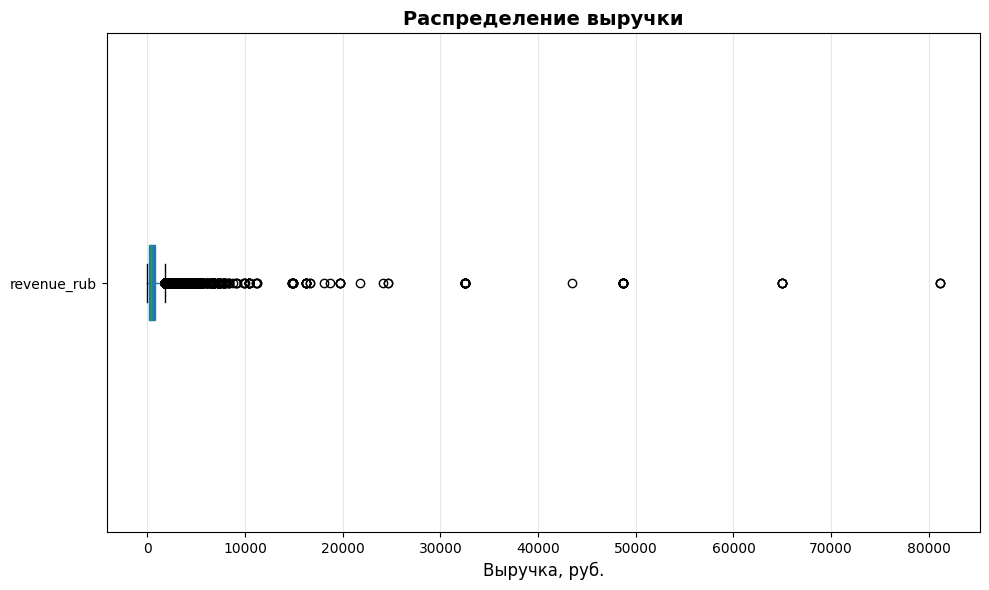

In [12]:
plt.figure(figsize=(10, 6))
data['revenue_rub'].plot(kind='box', vert=False, patch_artist=True)

plt.title('Распределение выручки', fontsize=14, fontweight='bold')
plt.xlabel('Выручка, руб.', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

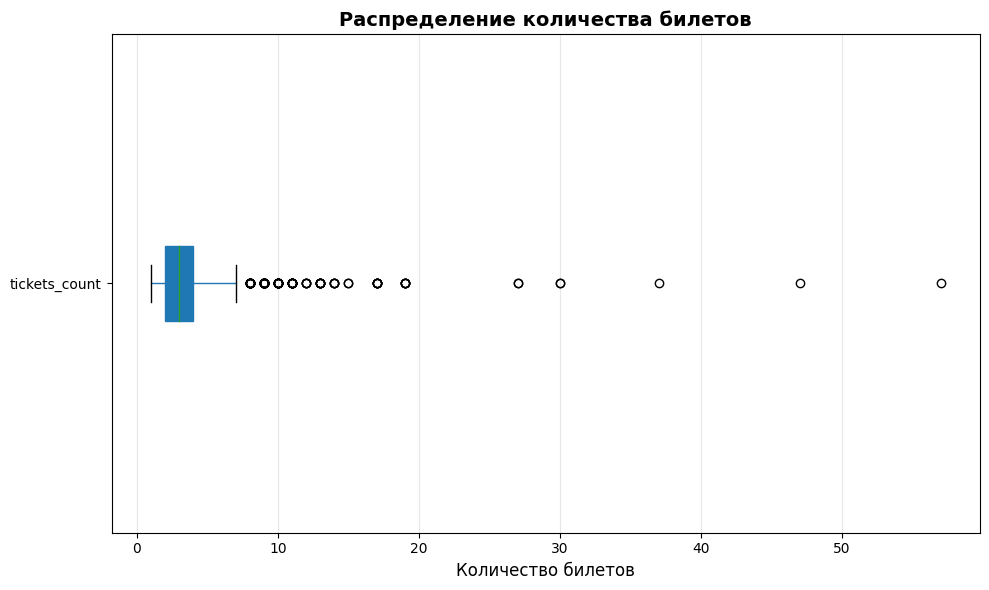

In [13]:
plt.figure(figsize=(10, 6))
data['tickets_count'].plot(kind='box', vert=False, patch_artist=True)

plt.title('Распределение количества билетов', fontsize=14, fontweight='bold')
plt.xlabel('Количество билетов', fontsize=12)
plt.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

In [14]:
data = data[(data['revenue_rub'] <= data['revenue_rub'].quantile(0.99)) & (data['tickets_count'] <= data['revenue_rub'].quantile(0.99))]
rows_after_filtred = len(data)
print(rows_before_filtred, rows_before_filtred - rows_after_filtred, round((rows_before_filtred - rows_after_filtred) / rows_before_filtred * 100, 2))

290611 2825 0.97


# Вывод 2:
* Добавлено новое поле для удобства расчётов revenue_rub, выраженное в рублях для строк в рублях и в тенге
* Пропуски имеются только в ожидаемом поле days_since_prev
* Отфильтрованы выбросы по 99 перцентилю
* Отфильтровано (выброшено) 2 825 из 290 611 записей (менее 1%)

# Шаг 3. Создание профиля пользователя
## Задача 3.1. Постройте профиль пользователя.

In [15]:
data = data.sort_values(['user_id', 'order_ts'])

user_profile = data.groupby('user_id').agg(
    first_order_dt=('order_dt', 'first'),
    last_order_dt=('order_dt', 'last'),
    first_device=('device_type_canonical', 'first'),
    first_region=('region_name', 'first'),
    first_service=('service_name', 'first'),
    first_event_type_main=('event_type_main', 'first'),
    orders_count=('order_id', 'count'),
    avg_revenue=('revenue_rub', 'mean'),
    avg_tickets=('tickets_count', 'mean'),
    avg_days_between=('days_since_prev', 'mean')
).reset_index()


def count_orders_categorize(row):
    if row['orders_count'] < 2:
        return False, False
    elif 2 <= row['orders_count'] < 5:
        return True, False
    else:
        return True, True


user_profile[['is_two', 'is_five']] = user_profile.apply(count_orders_categorize, axis=1, result_type='expand')

#user_profile.head(15)

## 3.1 Профиль пользователя создан

## Задача 3.2. Прежде чем проводить исследовательский анализ данных и делать выводы, важно понять, с какими данными вы работаете: насколько они репрезентативны и нет ли в них аномалий.

In [16]:
print('общее число пользователей в выборке:', user_profile['user_id'].nunique())
print('Средняя выручка с одного заказа:', round(user_profile['avg_revenue'].mean(), 2))
print('Доля пользователей, совершивших 2 и более заказа:', round(user_profile['is_two'].mean() * 100, 2), '%')
print('Доля пользователей, совершивших 5 и более заказов:', round(user_profile['is_five'].mean() * 100, 2), '%')

общее число пользователей в выборке: 21854
Средняя выручка с одного заказа: 544.4
Доля пользователей, совершивших 2 и более заказа: 61.71 %
Доля пользователей, совершивших 5 и более заказов: 29.01 %


In [17]:
user_profile[['orders_count', 'avg_tickets', 'avg_days_between']].describe()

,orders_count,avg_tickets,avg_days_between
count,21854.000000,21854.000000,13513.000000
mean,13.168573,2.743129,15.851275
std,121.674800,0.913080,22.306224
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,8.000000
75%,5.000000,3.076923,20.428571
max,10181.000000,11.000000,148.000000


Данных достаточно, но судя по стандартному отклонению присутствуют яркие аномалии в полях orders_count и avg_days_between, необходимо посмотреть на них детальней. Распределение avg_tickets нормальное.

In [18]:
rows_before_filtred = len(user_profile)
rows_before_filtred
std_orders_count_before = round(user_profile['orders_count'].std(), 2)
std_avg_days_between_before = round(user_profile['avg_days_between'].std(), 2)

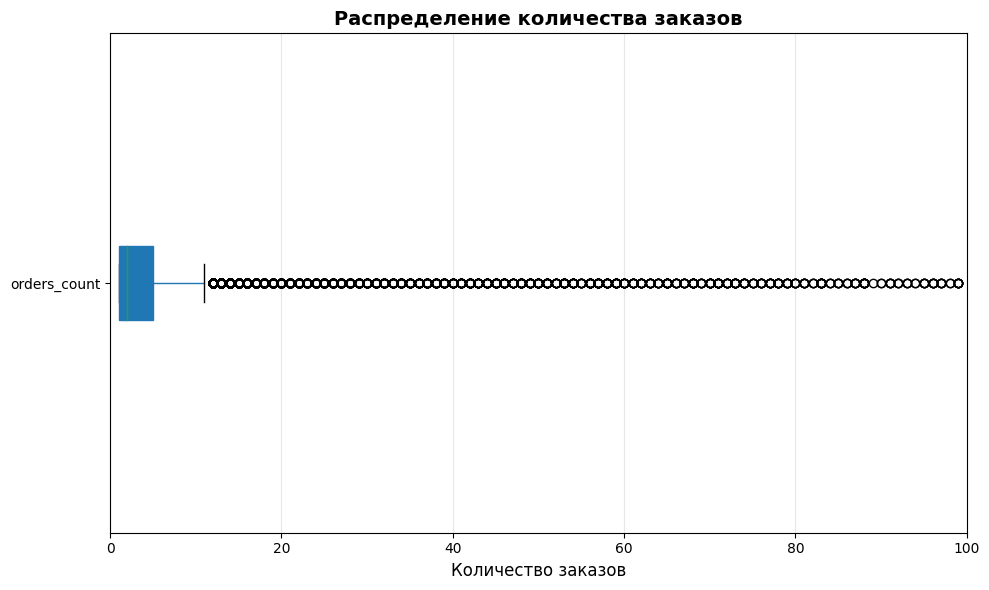

In [19]:
plt.figure(figsize=(10, 6))
user_profile['orders_count'].plot(kind='box', vert=False, patch_artist=True)

plt.title('Распределение количества заказов', fontsize=14, fontweight='bold')
plt.xlabel('Количество заказов', fontsize=12)
plt.grid(axis='x', alpha=0.3)


plt.xlim(0, 100)

plt.tight_layout()
plt.show()

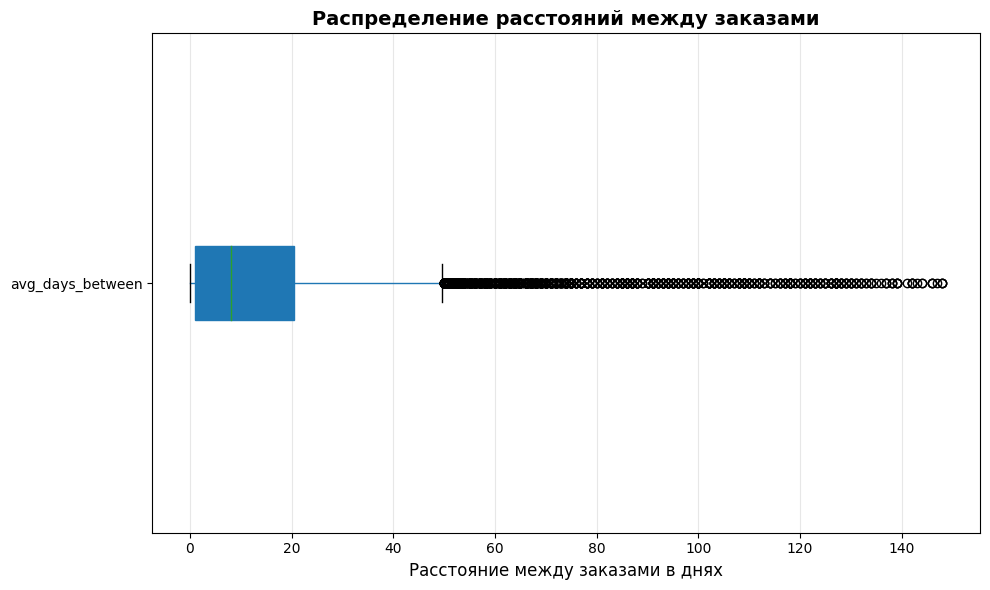

In [20]:
plt.figure(figsize=(10, 6))
user_profile['avg_days_between'].plot(kind='box', vert=False, patch_artist=True)

plt.title('Распределение расстояний между заказами', fontsize=14, fontweight='bold')
plt.xlabel('Расстояние между заказами в днях', fontsize=12)
plt.grid(axis='x', alpha=0.3)


#plt.xlim(0, 50)

plt.tight_layout()
plt.show()

Так как в обоих случаях, правый ус графика очень растянут, отфильтруем по 95 и 99 перцентилю и посмотрим сколько данных мы потеряем, и как изменится стандартное отклонение, выберем оптимальный вариант, который снизит стандартное отклонение и не отрежет много данных

In [21]:
user_profile_95 = user_profile[
    (user_profile['orders_count'] <= user_profile['orders_count'].quantile(0.95)) & 
    (
        (user_profile['avg_days_between'] <= user_profile['avg_days_between'].quantile(0.95)) | 
        (user_profile['avg_days_between'].isna())
    )
]
rows_after_filtred = len(user_profile_95)
std_orders_count_after = round(user_profile_95['orders_count'].std(), 2)
std_avg_days_between_after = round(user_profile_95['avg_days_between'].std(), 2)
part_filtred = round((rows_before_filtred - rows_after_filtred) / rows_before_filtred * 100, 2)
delta_std_orders_count = round(((std_orders_count_after / std_orders_count_before) - 1) * 100, 2)
delta_std_avg_days_between = round(((std_avg_days_between_after / std_avg_days_between_before) - 1) * 100, 2)
avg_delta = round((delta_std_orders_count + delta_std_avg_days_between) / 2, 2)

print('Результаты при фильтрах orders_count 95 перцентиль и avg_days_between 95 перцентиль')
print('Записей было:',rows_before_filtred, 'Записей удалено:', rows_before_filtred - rows_after_filtred, 'Доля удалённых записей:', part_filtred, '%')
print('Снижение стандартного отклонения: orders_count - c ', std_orders_count_before, 'до ', std_orders_count_after, ' - ', delta_std_orders_count, '%')
print('Снижение стандартного отклонения: avg_days_between - c ', std_avg_days_between_before, 'до ', std_avg_days_between_after, ' - ', delta_std_avg_days_between, '%')
print('Среднее снижение: ', avg_delta, '%')

Результаты при фильтрах orders_count 95 перцентиль и avg_days_between 95 перцентиль
Записей было: 21854 Записей удалено: 1768 Доля удалённых записей: 8.09 %
Снижение стандартного отклонения: orders_count - c  121.67 до  5.19  -  -95.73 %
Снижение стандартного отклонения: avg_days_between - c  22.31 до  13.94  -  -37.52 %
Среднее снижение:  -66.62 %


In [22]:
user_profile_99 = user_profile[
    (user_profile['orders_count'] <= user_profile['orders_count'].quantile(0.99)) & 
    (
        (user_profile['avg_days_between'] <= user_profile['avg_days_between'].quantile(0.99)) | 
        (user_profile['avg_days_between'].isna())
    )
]
rows_after_filtred = len(user_profile_99)
std_orders_count_after = round(user_profile_99['orders_count'].std(), 2)
std_avg_days_between_after = round(user_profile_99['avg_days_between'].std(), 2)
part_filtred = round((rows_before_filtred - rows_after_filtred) / rows_before_filtred * 100, 2)
delta_std_orders_count = round(((std_orders_count_after / std_orders_count_before) - 1) * 100, 2)
delta_std_avg_days_between = round(((std_avg_days_between_after / std_avg_days_between_before) - 1) * 100, 2)
avg_delta = round((delta_std_orders_count + delta_std_avg_days_between) / 2, 2)

print('Результаты при фильтрах orders_count 99 перцентиль и avg_days_between 99 перцентиль')
print('Записей было:',rows_before_filtred, 'Записей удалено:', rows_before_filtred - rows_after_filtred, 'Доля удалённых записей:', part_filtred, '%')
print('Снижение стандартного отклонения: orders_count - c ', std_orders_count_before, 'до ', std_orders_count_after, ' - ', delta_std_orders_count, '%')
print('Снижение стандартного отклонения: avg_days_between - c ', std_avg_days_between_before, 'до ', std_avg_days_between_after, ' - ', delta_std_avg_days_between, '%')
print('Среднее снижение: ', avg_delta, '%')

Результаты при фильтрах orders_count 99 перцентиль и avg_days_between 99 перцентиль
Записей было: 21854 Записей удалено: 350 Доля удалённых записей: 1.6 %
Снижение стандартного отклонения: orders_count - c  121.67 до  14.36  -  -88.2 %
Снижение стандартного отклонения: avg_days_between - c  22.31 до  19.49  -  -12.64 %
Среднее снижение:  -50.42 %


In [23]:
user_profile_95_99 = user_profile[
    (user_profile['orders_count'] <= user_profile['orders_count'].quantile(0.95)) & 
    (
        (user_profile['avg_days_between'] <= user_profile['avg_days_between'].quantile(0.99)) | 
        (user_profile['avg_days_between'].isna())
    )
]
rows_after_filtred = len(user_profile_95_99)
std_orders_count_after = round(user_profile_95_99['orders_count'].std(), 2)
std_avg_days_between_after = round(user_profile_95_99['avg_days_between'].std(), 2)
part_filtred = round((rows_before_filtred - rows_after_filtred) / rows_before_filtred * 100, 2)
delta_std_orders_count = round(((std_orders_count_after / std_orders_count_before) - 1) * 100, 2)
delta_std_avg_days_between = round(((std_avg_days_between_after / std_avg_days_between_before) - 1) * 100, 2)
avg_delta = round((delta_std_orders_count + delta_std_avg_days_between) / 2, 2)

print('Результаты при фильтрах orders_count 95 перцентиль и avg_days_between 99 перцентиль')
print('Записей было:',rows_before_filtred, 'Записей удалено:', rows_before_filtred - rows_after_filtred, 'Доля удалённых записей:', part_filtred, '%')
print('Снижение стандартного отклонения: orders_count - c ', std_orders_count_before, 'до ', std_orders_count_after, ' - ', delta_std_orders_count, '%')
print('Снижение стандартного отклонения: avg_days_between - c ', std_avg_days_between_before, 'до ', std_avg_days_between_after, ' - ', delta_std_avg_days_between, '%')
print('Среднее снижение: ', avg_delta, '%')

Результаты при фильтрах orders_count 95 перцентиль и avg_days_between 99 перцентиль
Записей было: 21854 Записей удалено: 1227 Доля удалённых записей: 5.61 %
Снижение стандартного отклонения: orders_count - c  121.67 до  5.13  -  -95.78 %
Снижение стандартного отклонения: avg_days_between - c  22.31 до  19.87  -  -10.94 %
Среднее снижение:  -53.36 %


In [24]:
user_profile_99_95 = user_profile[
    (user_profile['orders_count'] <= user_profile['orders_count'].quantile(0.99)) & 
    (
        (user_profile['avg_days_between'] <= user_profile['avg_days_between'].quantile(0.95)) | 
        (user_profile['avg_days_between'].isna())
    )
]
rows_after_filtred = len(user_profile_99_95)
std_orders_count_after = round(user_profile_99_95['orders_count'].std(), 2)
std_avg_days_between_after = round(user_profile_99_95['avg_days_between'].std(), 2)
part_filtred = round((rows_before_filtred - rows_after_filtred) / rows_before_filtred * 100, 2)
delta_std_orders_count = round(((std_orders_count_after / std_orders_count_before) - 1) * 100, 2)
delta_std_avg_days_between = round(((std_avg_days_between_after / std_avg_days_between_before) - 1) * 100, 2)
avg_delta = round((delta_std_orders_count + delta_std_avg_days_between) / 2, 2)

print('Результаты при фильтрах orders_count 99 перцентиль и avg_days_between 95 перцентиль')
print('Записей было:',rows_before_filtred, 'Записей удалено:', rows_before_filtred - rows_after_filtred, 'Доля удалённых записей:', part_filtred, '%')
print('Снижение стандартного отклонения: orders_count - c ', std_orders_count_before, 'до ', std_orders_count_after, ' - ', delta_std_orders_count, '%')
print('Снижение стандартного отклонения: avg_days_between - c ', std_avg_days_between_before, 'до ', std_avg_days_between_after, ' - ', delta_std_avg_days_between, '%')
print('Среднее снижение: ', avg_delta, '%')

Результаты при фильтрах orders_count 99 перцентиль и avg_days_between 95 перцентиль
Записей было: 21854 Записей удалено: 891 Доля удалённых записей: 4.08 %
Снижение стандартного отклонения: orders_count - c  121.67 до  14.53  -  -88.06 %
Снижение стандартного отклонения: avg_days_between - c  22.31 до  13.7  -  -38.59 %
Среднее снижение:  -63.32 %


In [25]:
user_profile = user_profile_99_95
user_profile[['orders_count', 'avg_tickets', 'avg_days_between']].describe()

,orders_count,avg_tickets,avg_days_between
count,20963.000000,20963.000000,12622.000000
mean,6.642513,2.741653,12.116318
std,14.530710,0.919303,13.698341
min,1.000000,1.000000,0.000000
25%,1.000000,2.000000,1.000000
50%,2.000000,2.750000,7.562500
75%,5.000000,3.085463,18.000000
max,152.000000,11.000000,61.500000


## Вывод 3.2
Данные были отфильтрованы по 99 перцентилю по orders_count и по 95 перцентилю по avg_days_between, так как теряем всего 891 запись (4.08%), но снижаем стандартное отклонение в среднем на 63%, а именно по orders_count - c  121.67 до  14.53 (-88.06 %), а по avg_days_between - c  22.31 до  13.7 (-38.59 %)

# Шаг 4. Исследовательский анализ данных
## 4.1. Исследование признаков первого заказа и их связи с возвращением на платформу
### Задача 4.1.1. Изучите распределение пользователей по признакам.
Напишем функцию которая разделит данные на сегменты, посчитает количество и долю пользователей

In [26]:
def segmentation_profile(data, sing):
    result = data.groupby(f'{sing}').agg(
    count_users=('user_id', 'count'),
    part_is_two=('is_two', 'mean')
).reset_index()
    result['part_is_two'] = round(result['part_is_two'] * 100, 2)
    result['part_users'] = round(result['count_users'] / result['count_users'].sum() * 100, 2)
    result = result.sort_values(by='part_users', ascending=False)
    return result

Применим функцию к каждому интересующему нас признаку и поищем выраженные "точки входа"

In [27]:
sign_list = ['first_event_type_main', 'first_device', 'first_region', 'first_service']
for i in sign_list:
    print('Сегментация по ', i)
    display(segmentation_profile(user_profile, i).head(10))

Сегментация по  first_event_type_main


,first_event_type_main,count_users,part_is_two,part_users
2,концерты,9240,60.56,44.08
1,другое,5277,58.52,25.17
5,театр,4097,62.12,19.54
4,стендап,1073,59.55,5.12
3,спорт,788,55.46,3.76
0,выставки,394,62.18,1.88
6,ёлки,94,55.32,0.45


Сегментация по  first_device


,first_device,count_users,part_is_two,part_users
1,mobile,17377,59.62,82.89
0,desktop,3586,62.52,17.11


Сегментация по  first_region


,first_region,count_users,part_is_two,part_users
23,Каменевский регион,6820,60.97,32.53
60,Североярская область,3640,62.58,17.36
77,Широковская область,1183,63.31,5.64
45,Озернинский край,657,54.03,3.13
41,Малиновоярский округ,512,54.88,2.44
76,Шанырский регион,482,65.98,2.30
74,Травяная область,470,60.00,2.24
57,Светополянский округ,445,64.72,2.12
52,Речиновская область,425,62.59,2.03
78,Яблоневская область,404,58.66,1.93


Сегментация по  first_service


,first_service,count_users,part_is_two,part_users
3,Билеты без проблем,5024,59.16,23.97
22,Мой билет,2890,59.86,13.79
19,Лови билет!,2721,59.65,12.98
4,Билеты в руки,2480,61.57,11.83
23,Облачко,2102,59.94,10.03
7,Весь в билетах,1236,61.41,5.90
20,Лучшие билеты,1161,60.47,5.54
24,Прачечная,565,61.42,2.70
17,Край билетов,437,63.84,2.08
12,Дом культуры,342,63.16,1.63


## 4.1. Вывод: яркие "точки входа": концерты (44% пользователей), мобильные устройства (83% пользователей), Каменевский регион (33% пользователей) и сервис "Билеты без проблем" (24% пользователей)

### Задача 4.1.2. Проанализируйте возвраты пользователей
Доработаем функцию segmentation_profile (доработал в ячейке выше), добавим расчёт доли возвратов пользователей (2 и более заказа) и построим графики

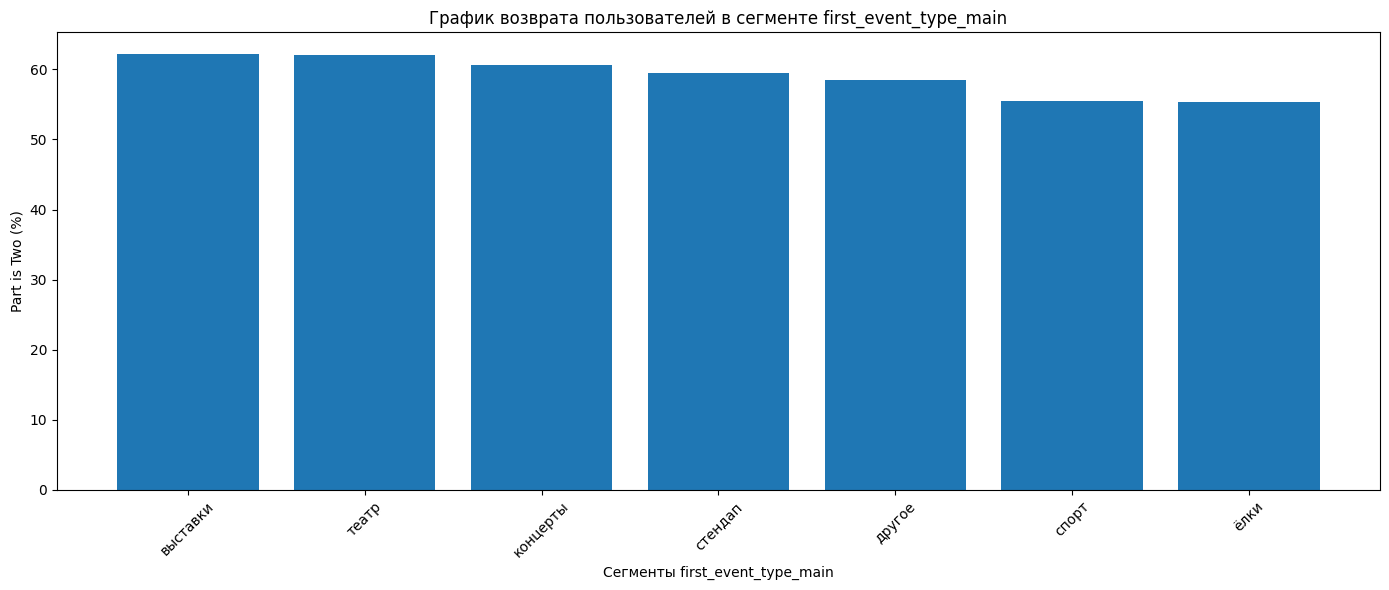

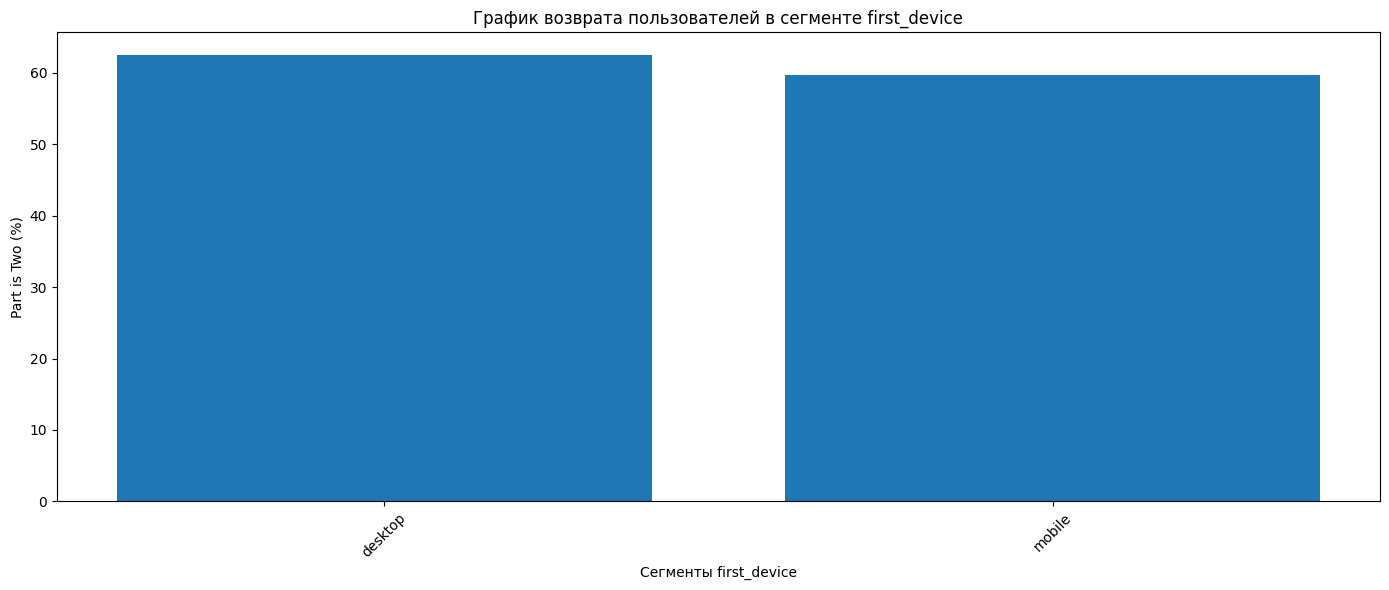

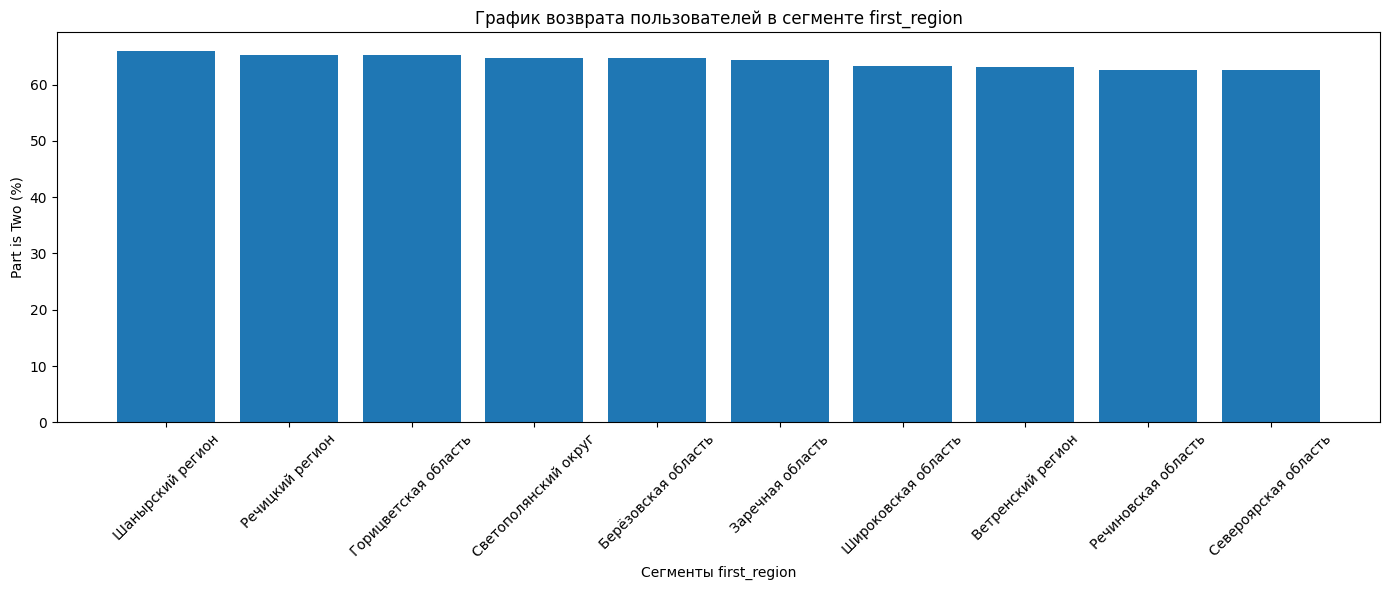

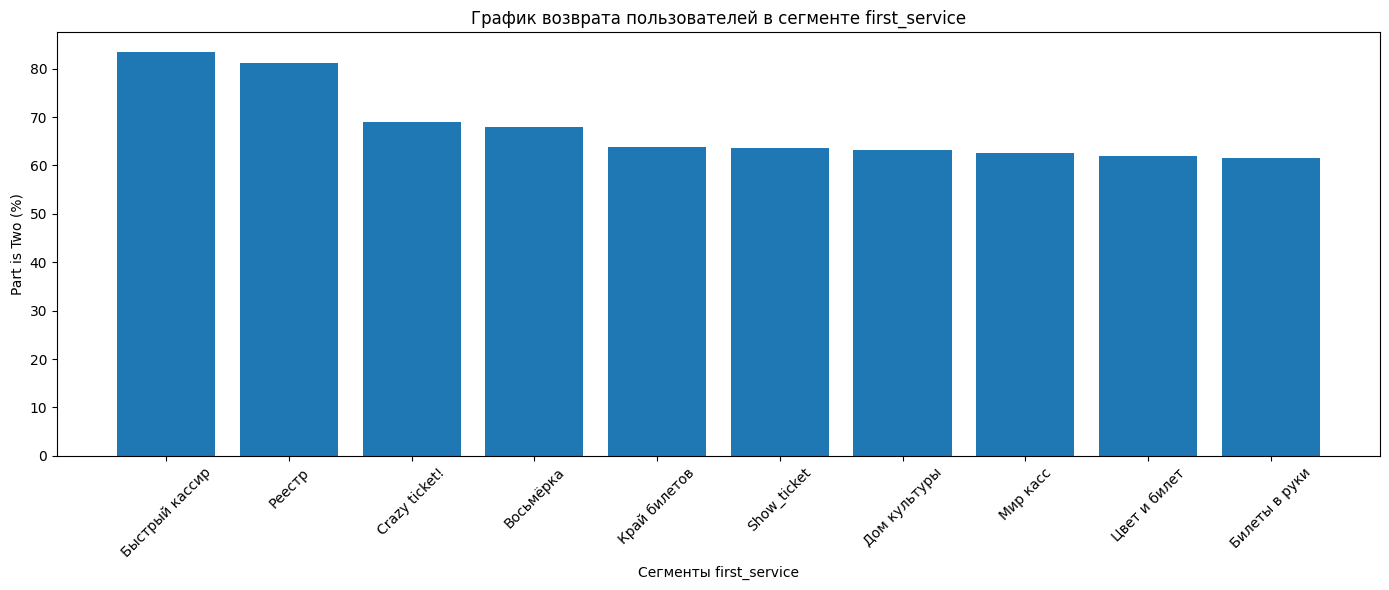

In [28]:
for i in sign_list:
    data_for_graph = segmentation_profile(user_profile, i)[[f'{i}', 'count_users', 'part_is_two']].sort_values(by='count_users', ascending=False).head(30)
    data_for_graph = data_for_graph[[f'{i}', 'part_is_two']].sort_values(by='part_is_two', ascending=False).head(10)
    plt.figure(figsize=(14, 6))
    plt.bar(data_for_graph[f'{i}'], data_for_graph['part_is_two'])
    plt.title(f'График возврата пользователей в сегменте {i}')
    plt.xlabel(f'Сегменты {i}')
    plt.ylabel('Part is Two (%)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

### 4.1.2. Вывод: 
Чаще всего возвращаются такие сегменты как:
* По мероприятиям это театры и выставки (более 60%)
* По устройствам - с мобильных устройств возвращаются реже, чем с десктоп, но не значительно (60% против 63%)
* По регионам ярких лидеров нет, по всем регионам возвращается чуть более чем 60% пользователей Верхозёрский край (100%)
* По операторам "Быстрый кассир" и "Реестр", вовзращается более 80% пользователей
Что бы исключить мелкие сегменты, отбирал первые 30 сегментов по убыванию количества пользователей в сегменте

### Задача 4.1.3. Опираясь на выводы из задач выше, проверьте продуктовые гипотезы

### Гипотеза 1. Тип мероприятия влияет на вероятность возврата на Яндекс Афишу: пользователи, которые совершили первый заказ на спортивные мероприятия, совершают повторный заказ чаще, чем пользователи, оформившие свой первый заказ на концерты.

Проверка гипотезы 1 опираясь на выводы выше:
Нет, 55% пользователей которые совершили первый заказ на спортивные мероприятия вернулись, а с концертов вернулись 61% пользователей
В данной формулировке гипотеза не подтвердилась

### Гипотеза 2. В регионах, где больше всего пользователей посещают мероприятия, выше доля повторных заказов, чем в менее активных регионах.

Проверка гипотезы 2 опираясь на выводы выше:
Топ 3 региона по посещаемости мероприятия это Каменевский регион, Североярская область, Широковская область. Доля возврата в них примерно такая же как в остальных, около 60%
Гипотеза не подтвердилась

## 4.2. Исследование поведения пользователей через показатели выручки и состава заказа
### Задача 4.2.1. Проследите связь между средней выручкой сервиса с заказа и повторными заказами.

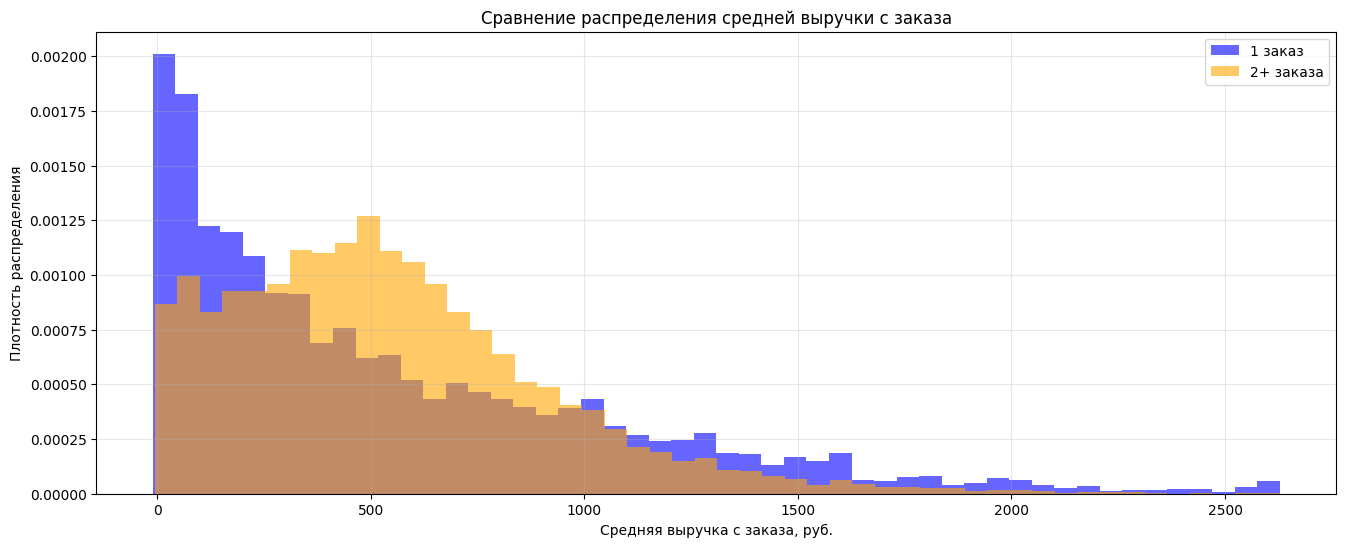

In [29]:
plt.figure(figsize=(16, 6))

one_order = user_profile[user_profile['is_two'] == False]['avg_revenue']
two_plus_orders = user_profile[user_profile['is_two'] == True]['avg_revenue']
bins = 50
alpha = 0.6
plt.hist(one_order, bins=bins, alpha=alpha, density=True, 
         label='1 заказ', color='blue')
plt.hist(two_plus_orders, bins=bins, alpha=alpha, density=True, 
         label='2+ заказа', color='orange')

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с заказа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.2.1. Вывод:
* Пользователи с 1 заказом концентрируются в диапазоне выручки от 0 до 500 рублей, с пиком около 100 рублей
* Пользователе с более чем 1 заказом концентрируются в диапазоне выручки от 0 до 1000 рублей с пиком около 500 рублей
* Различе между группами состоит в том, что распределение возвращающихся клиентов больше похоже на нормальное и равномерное, в то время как покупатели с одним заказом сильно сконцентрированы около минимальной прибыли, и далее распределение идёт на спад

### Задача 4.2.2. Сравните распределение по средней выручке с заказа в двух группах пользователей:

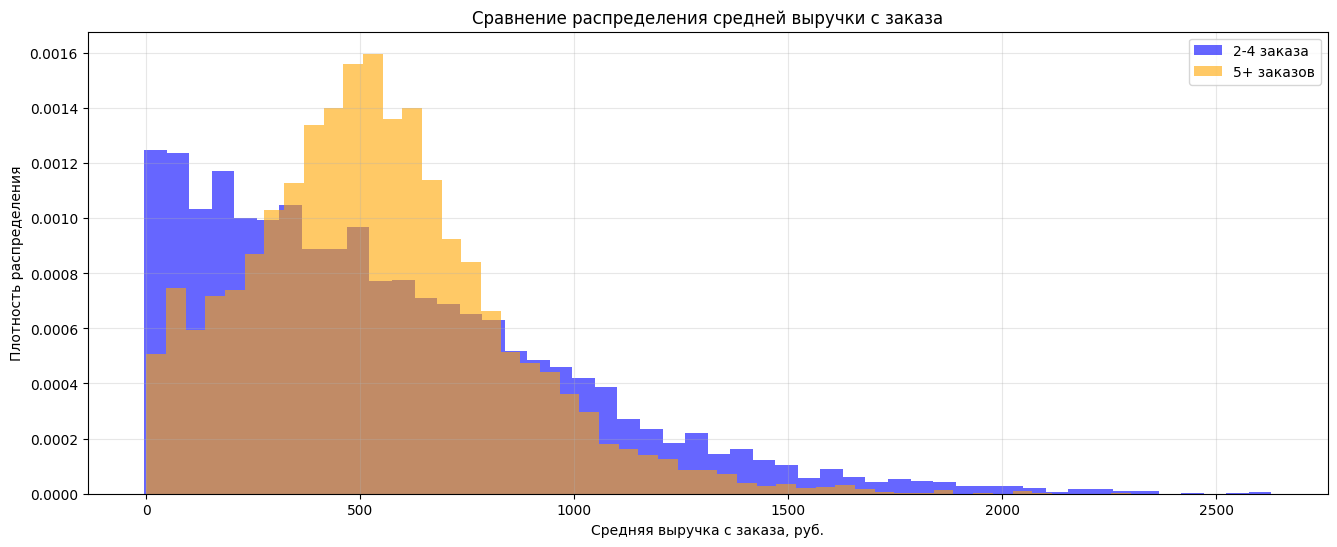

In [30]:
plt.figure(figsize=(16, 6))

two_four_orders = user_profile[(user_profile['is_two'] == True) & (user_profile['is_five'] == False)]['avg_revenue']
five_plus_orders = user_profile[user_profile['is_five'] == True]['avg_revenue']
bins = 50
alpha = 0.6
plt.hist(two_four_orders, bins=bins, alpha=alpha, density=True, 
         label='2-4 заказа', color='blue')
plt.hist(five_plus_orders, bins=bins, alpha=alpha, density=True, 
         label='5+ заказов', color='orange')

plt.xlabel('Средняя выручка с заказа, руб.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения средней выручки с заказа')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.2.2. Вывод:
* Пользователи у которых 2-4 заказа концентрируются в диапазоне выручки от 0 до 1000 рублей, с пиком около 100 рублей
* Пользователе с более чем 5 заказами концентрируются в том же диапазоне выручки от 0 до 1000 рублей, но с пиком 500 рублей
* Различе между группами состоит в том, что распределение клиентов с 5 и более заказами больше похоже на нормальное и равномерное, в то время как покупатели у которых 2-4 заказа стабильно теряют вес при росте выручки.

### Задача 4.2.3. Проанализируйте влияние среднего количества билетов в заказе на вероятность повторной покупки.
Напишем функцию для категоризации пользователей по количеству билетов

In [31]:
def categorize_tickets_count(row):
    if row['avg_tickets'] < 2:
        return 'от 1 до 2 билетов'
    elif 2 <= row['avg_tickets'] < 3:
        return 'от 2 до 3 билетов'
    elif 3 <= row['avg_tickets'] < 5:
        return 'от 3 до 5 билетов'
    else:
        return 'от 5 и более билетов'

user_profile['category_tickets_count'] = user_profile.apply(categorize_tickets_count, axis=1)

Для расчёта количества пользователей и доли возврата подойдёт функция 

In [32]:
segmentation_profile(user_profile, 'category_tickets_count')

,category_tickets_count,count_users,part_is_two,part_users
1,от 2 до 3 билетов,9246,72.89,44.11
2,от 3 до 5 билетов,8719,52.53,41.59
0,от 1 до 2 билетов,2342,49.70,11.17
3,от 5 и более билетов,656,18.14,3.13


### 4.2.3. Вывод:
* Пользователи распределены по сегментам не равномерно: почти все пользователи (86%) попали в сегменты между 2 и 5 билетами, 11% от 1 до 2 билетов, и всего 3% имеют более 5 билетов
* Среди пользователей сегмента 2-3 билета очень высокая доля возврата (73%), а среди сегмента 5+ билетов, возвращается очень мало (18%)

## 4.3. Исследование временных характеристик первого заказа и их влияния на повторные покупки

Изучим временные параметры: день недели первой покупки, время с момента первой покупки - лайфтайм, а так же рассчитаем средний интервал между покупками пользователей с повторными заказами

In [33]:
user_profile['day_week_first_order'] = user_profile['first_order_dt'].dt.weekday
days_mapping = {
    0: 'Понедельник',
    1: 'Вторник', 
    2: 'Среда',
    3: 'Четверг',
    4: 'Пятница',
    5: 'Суббота',
    6: 'Воскресенье'
}
user_profile['day_week_first_order'] = user_profile['day_week_first_order'].map(days_mapping)

user_profile['lifetime'] = user_profile['last_order_dt'] - user_profile['first_order_dt']
#user_profile.head(10)

In [34]:
user_profile.head()

,user_id,first_order_dt,last_order_dt,first_device,first_region,first_service,first_event_type_main,orders_count,avg_revenue,avg_tickets,avg_days_between,is_two,is_five,category_tickets_count,day_week_first_order,lifetime
0,0002849b70a3ce2,2024-08-20,2024-08-20,mobile,Каменевский регион,Край билетов,театр,1,1521.940000,4.000000,NaN,False,False,от 3 до 5 билетов,Вторник,0 days
2,000898990054619,2024-07-13,2024-10-23,mobile,Североярская область,Лови билет!,другое,3,767.213333,2.666667,51.000000,True,False,от 2 до 3 билетов,Суббота,102 days
3,00096d1f542ab2b,2024-08-15,2024-08-15,desktop,Каменевский регион,Край билетов,театр,1,917.830000,4.000000,NaN,False,False,от 3 до 5 билетов,Четверг,0 days
4,000a55a418c128c,2024-09-29,2024-10-15,mobile,Поленовский край,Лучшие билеты,театр,2,61.310000,1.500000,16.000000,True,False,от 1 до 2 билетов,Воскресенье,16 days
5,000cf0659a9f40f,2024-06-20,2024-06-21,mobile,Широковская область,Лови билет!,концерты,13,1175.808462,3.307692,0.083333,True,True,от 3 до 5 билетов,Четверг,1 days


### Задача 4.3.1. Проанализируйте, как день недели, в которой была совершена первая покупка, влияет на поведение пользователей.

Посчитаю для каждого дня недели общее число пользователей и долю пользователей, совершивших повторные заказы с помощью функции segmentation_profile

In [35]:
segmentation_profile(user_profile, 'day_week_first_order')

,day_week_first_order,count_users,part_is_two,part_users
5,Суббота,3212,61.49,15.32
3,Пятница,3156,58.62,15.06
1,Вторник,3078,60.75,14.68
6,Четверг,3038,58.43,14.49
4,Среда,2965,61.01,14.14
2,Понедельник,2827,61.73,13.49
0,Воскресенье,2687,58.73,12.82


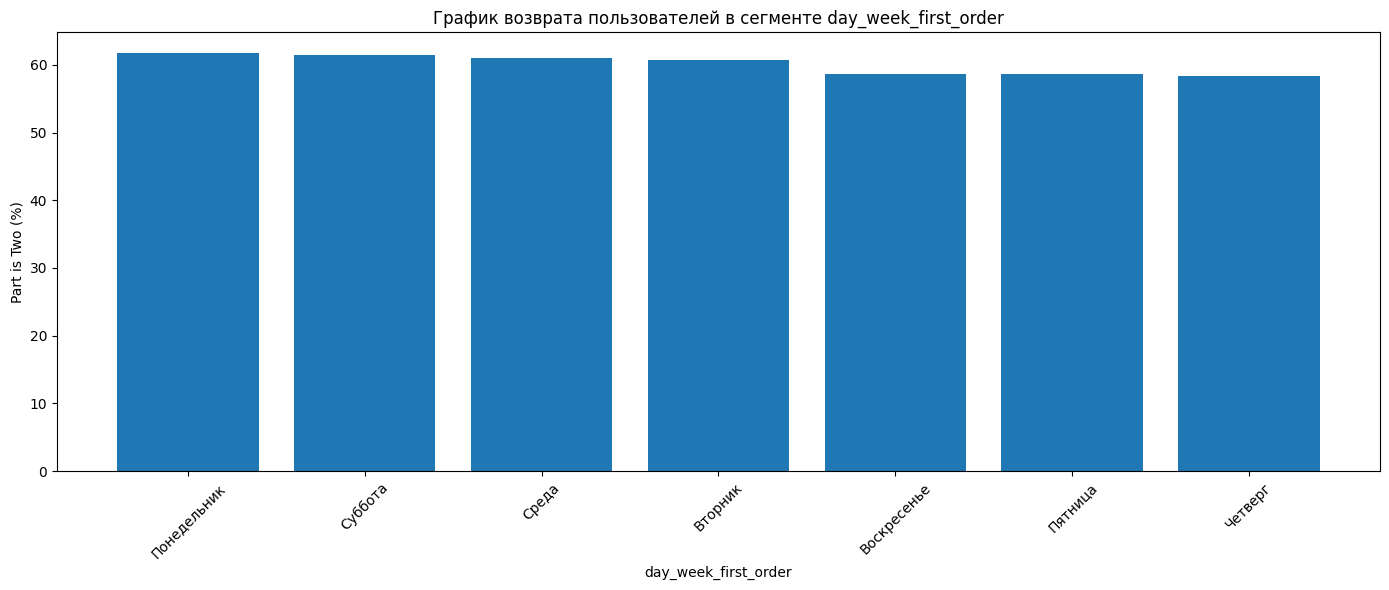

In [36]:
data_for_graph = segmentation_profile(user_profile, 'day_week_first_order')[['day_week_first_order', 'part_is_two']].sort_values(by='part_is_two', ascending=False)

plt.figure(figsize=(14, 6))
plt.bar(data_for_graph['day_week_first_order'], data_for_graph['part_is_two'])
plt.title(f'График возврата пользователей в сегменте day_week_first_order')
plt.xlabel('day_week_first_order')
plt.ylabel('Part is Two (%)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### 4.3.1. Вывод:
День недели, в которую совершена первая покупка, не влияет на вероятность возврата клиента. В любой день недели доля возвращающихся клиентов от 59% до 61%

### Задача 4.3.2. Изучите, как средний интервал между заказами влияет на удержание клиентов.

In [37]:
user_profile['lifetime'] = user_profile['lifetime'].dt.days.astype('int32')

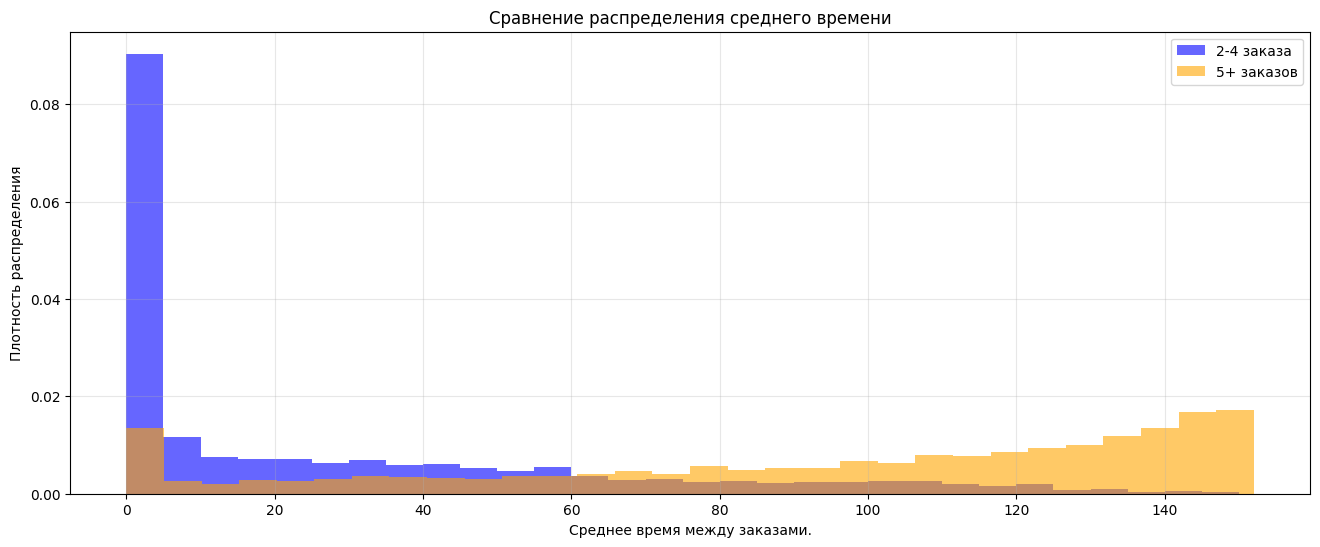

In [38]:
plt.figure(figsize=(16, 6))

two_four_orders = user_profile[(user_profile['is_two'] == True) & (user_profile['is_five'] == False)]['lifetime']
five_plus_orders = user_profile[user_profile['is_five'] == True]['lifetime']
bins = 30
alpha = 0.6
plt.hist(two_four_orders, bins=bins, alpha=alpha, density=True, 
         label='2-4 заказа', color='blue')
plt.hist(five_plus_orders, bins=bins, alpha=alpha, density=True, 
         label='5+ заказов', color='orange')

plt.xlabel('Среднее время между заказами.')
plt.ylabel('Плотность распределения')
plt.title('Сравнение распределения среднего времени')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Вывод 4.3.2. 
Самая высокая вероятность повторного заказа расположена на интервале от 0 до 5 дней между заказами

## 4.4. Корреляционный анализ количества покупок и признаков пользователя
### Задача 4.4.1: Проведите корреляционный анализ
Сначала рассчитаем коэффициент корреляции phi_k между признаками профиля пользователя и числом заказов ( total_orders )

In [39]:
user_profile.columns

Index(['user_id', 'first_order_dt', 'last_order_dt', 'first_device',
       'first_region', 'first_service', 'first_event_type_main',
       'orders_count', 'avg_revenue', 'avg_tickets', 'avg_days_between',
       'is_two', 'is_five', 'category_tickets_count', 'day_week_first_order',
       'lifetime'],
      dtype='object')

Корреляционная матрица с коэффициентом phi_k для переменной orders_count


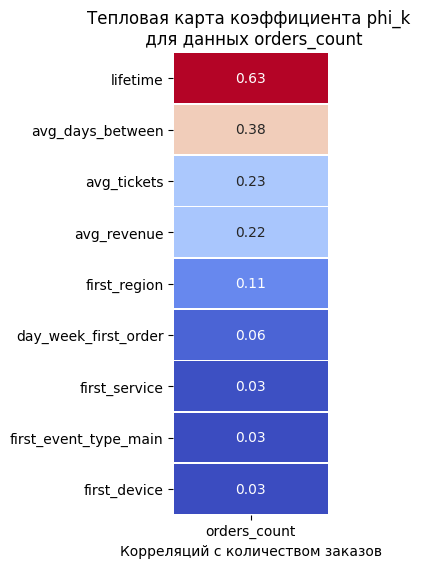

In [40]:
# Вычисляем корреляционную матрицу с использованием phi_k
interval_cols = ['avg_revenue', 'avg_tickets', 'avg_days_between', 'lifetime', 'orders_count']

correlation_matrix = user_profile[['first_device', 'first_region', 'first_service', 'first_event_type_main',
                         'avg_revenue', 'avg_tickets', 'avg_days_between',
                         'day_week_first_order', 'lifetime', 'orders_count']].phik_matrix(interval_cols=interval_cols)

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной orders_count')
#correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака churn с другими признаками клиента
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных orders_count')
plt.xlabel('Корреляций с количеством заказов')

# Выводим график
plt.show()

Посмотрим на корреляцию по сегментам (количество заказов) предварительно разделим данные на сегменты

In [41]:
def categorize_orders_count(row):
    if row['orders_count'] == 1:
        return '1 заказ'
    elif 2 <= row['orders_count'] <= 4:
        return 'от 2 до 4 заказов'
    else:
        return 'от 5 заказов'

user_profile['category_order_count'] = user_profile.apply(categorize_orders_count, axis=1)


Корреляционная матрица с коэффициентом phi_k для переменной category_order_count


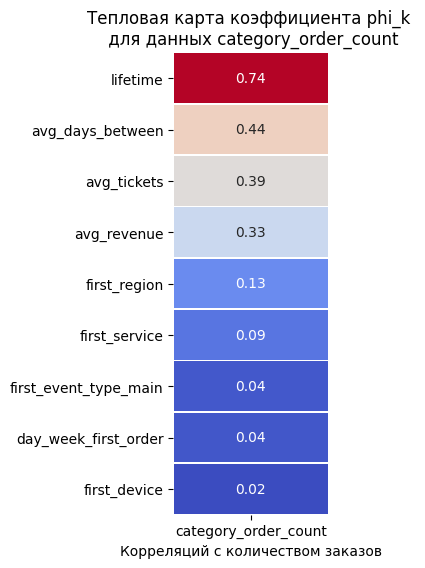

In [42]:
# Вычисляем корреляционную матрицу с использованием phi_k
interval_cols = ['avg_revenue', 'avg_tickets', 'avg_days_between', 'lifetime']

correlation_matrix = user_profile[['first_device', 'first_region', 'first_service', 'first_event_type_main',
                         'avg_revenue', 'avg_tickets', 'avg_days_between',
                         'day_week_first_order', 'lifetime', 'category_order_count']].phik_matrix(interval_cols=interval_cols)

# Выводим результат
print('Корреляционная матрица с коэффициентом phi_k для переменной category_order_count')
#correlation_matrix.loc[correlation_matrix.index != 'orders_count'][['orders_count']].sort_values(by='orders_count', ascending=False)
# Строим тепловую карту
plt.figure(figsize=(2, 6))

# Сохраняем матрицу корреляции признака churn с другими признаками клиента
data_heatmap = correlation_matrix.loc[correlation_matrix.index != 'category_order_count'][['category_order_count']].sort_values(by='category_order_count', ascending=False)
sns.heatmap(data_heatmap,
            annot=True, # Отображаем численные значения в ячейках карты
            fmt='.2f', # Форматируем значения корреляции: два знака после точки
            cmap='coolwarm', # Устанавливаем цветовую гамму от красного (макс. значение) к синему
            linewidths=0.5, # Форматируем линию между ячейками карты
            cbar=False # Отключаем цветовую шкалу
           )

# Добавляем заголовок и подпись по оси Х
plt.title('Тепловая карта коэффициента phi_k \n для данных category_order_count')
plt.xlabel('Корреляций с количеством заказов')

# Выводим график
plt.show()

### Вывод 4.4.1:
* Самую крепкую корреляцию с количествоми заказов в обоих случаях имеет признак lifetime, в случае с сегментированием 0.74
* Умеренная корреляция, при расчёте с учётом сегментирования имеется с признаками avg_days_between, avg_tickets, avg_revenue
* По остальным признакам корреляция слабая, я бы даже назвал её незначительной

# 5. Общие выводы и рекомендации
### Выводы
Информация о данных:
* Были получены и обработанны данные из 290 611 записей с заказами на Яндекс.Афиша
* Для удобства расчётов расчёт выручки в тенге был переведён в рубли, по курсу на день заказа
* Для экономии вычислительных ресурсов некоторые типы полей были изменены на более компактные (order_id, event_id, tickets_count)
* Для более качественного анализы были отброшены выбросы по полям revenue_rub и tickets_count
* Из этих данных был собран профиль пользователя с полями: first_order_dt, last_order_dt, first_device, first_region, first_service, first_event_type_main, orders_count, avg_revenue, avg_tickets, avg_days_between, is_two, is_five

Основные результаты анализа:
* Всего пользователей: 20 963
Лидирующие категории среди первых заказов по количеству пользователей:
* Мероприятие - концерты (44%)
* Девайс - Мобильный (83%)
* Регион - Каменевский регион (33%)
* Оператор - Билеты без проблем (24%)

Доля возврата пользователей по сегментам first_event_type_main, first_device, first_region, first_service около 60%
Выделяются только операторы "Быстрый кассир" и "Реестр" с долдей возврата около 80%

Самая сильная связь количества (прямая корреляция) с признаком lifetime

### Рекоммендации
* Очень важно попытаться вернуть клиентов с 1 заказом, им необходимо разослать промокоды на следующие мероприятия, и предложить подборку похожих (или повторяющихся мероприятий) на те, которые они посещали ранее
* Пользователей которые покупают много билетов, так же можно мотивировать скидками, это увеличит выручку

**Вставьте ссылку на проект в этой ячейке тетрадки перед отправкой проекта на ревью.**

Ссылка: 